# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.4
import pkg_resources
pkg_resources.require("networkx==2.4")
import networkx as nx

  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)
  Using cached decorator-4.4.1-py2.py3-none-any.whl (9.2 kB)


In [2]:
nx.__version__ # should be 2.1

'2.4'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sampling_probabilistic_roadmap import Sampler
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [6]:
print(data[:, 0])

[-310.2389 -300.2389 -290.2389 ...  257.8061  293.9967  281.5162]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [7]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision
from sampling_probabilistic_roadmap import Sampler
sampler = Sampler(data)
polygons = sampler._polygons

In [8]:
#nodes = np.array(sampler.sample(300))
nodes = sampler.sample(300)
print(len(nodes))
print(np.size(nodes))
nodes

197
591


[(561.4439597749135, -289.3322693627265, 7.35797939415731),
 (525.9441548082675, 259.83271821227424, 16.767182141074993),
 (50.762698999718225, 313.14193142956276, 18.404733321790083),
 (-88.23651260767161, 57.70103152651939, 0.9687912900176965),
 (-293.2303493817116, 426.96426674864927, 12.804894117903977),
 (458.23402840991906, -133.48108025176805, 0.8670889806612991),
 (-69.28713409989334, 382.780466828493, 9.527763241887154),
 (-39.51036857110205, -331.27269958740544, 16.823688703942473),
 (12.825887874430634, -77.7904549941722, 0.984386988645094),
 (-130.77308959867747, -337.15104050332263, 8.680262355405679),
 (389.48612289246233, -184.3842725360269, 4.313085362631819),
 (-220.98822744540507, 354.8408999858898, 1.025430793173041),
 (-85.21440931393334, 43.515547024818886, 15.072381870940692),
 (255.60417412335215, 382.2850453332678, 13.433865923157654),
 (2.0473335174031604, 231.34023386206866, 3.036853713929104),
 (276.77779496434385, 293.60819945565913, 2.0706061847852952),
 (4

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [9]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
import numpy.linalg as LA
from sklearn.neighbors import KDTree

In [10]:
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

In [11]:
nds = np.array(nodes) #KDTree 사용을 위해 nodes 배열

In [12]:
def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nds)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2==n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1) # add_edge에 파라미터 넣기 위해, (1,2,3) 형태의 vector 값을 넣어야함.
    return g

In [13]:
import time
t0 = time.time()
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 0.0 seconds to build


In [14]:
g = create_graph(nodes, 10)

In [15]:
print("Number of edges", len(g.edges))

Number of edges 521


## Step 4 - Visualize Graph

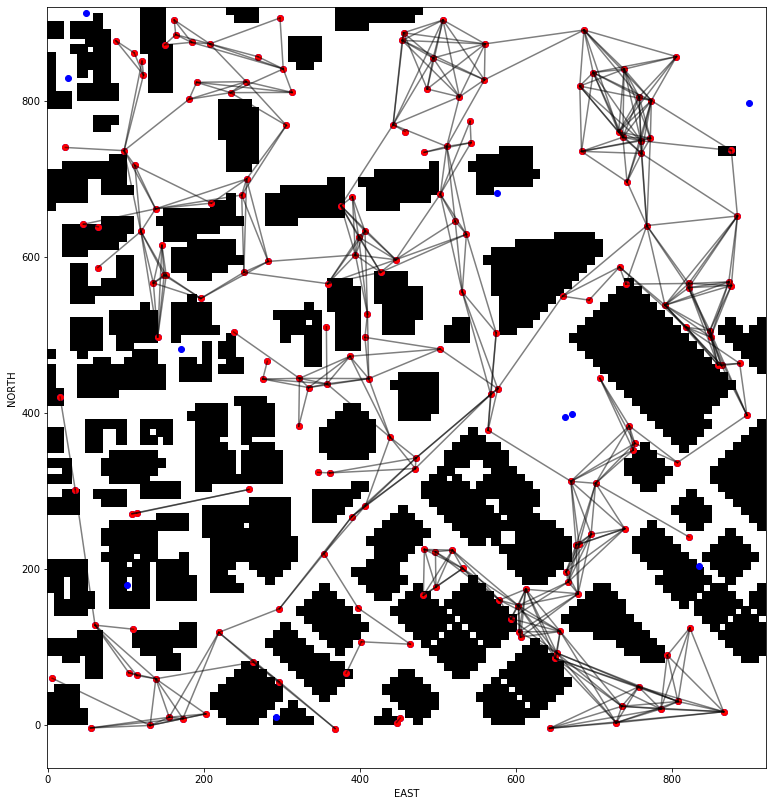

In [16]:
# Create a grid map of the world
from grid_probabilistic_roadmap import create_grid
# This will create a grid map at 1 m above ground level
#grid = create_grid(data, 1, 1)
grid = create_grid(data, sampler._zmax, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
#    plt.plot([n1[0] - nmin, n2[0] - nmin], [n1[1] - emin, n2[1] - emin], 'black' , alpha=0.5)
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
#    plt.scatter(n1[0] - nmin, n1[1] - emin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
#    plt.scatter(n1[0] - nmin, n1[1] - emin, c='red')    


plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

## Step 5 - Define Heuristic

In [17]:
def heuristic(n1, n2):
    # TODO: complete
    return LA.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [18]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [19]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes)) # 출발, 도착 지점 g에 저장되어 있는 nodes 중에 랜덤으로 생성
goal = list(g.nodes)[k]

87 187


In [20]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)
cost

Found a path.
16 [(561.4439597749135, -289.3322693627265, 7.35797939415731), (564.6415004998394, -254.78247081599199, 18.213202448684424), (530.5965103532797, -137.40255773117008, 17.590915881320722), (500.1754555017889, -204.89232961940388, 9.941208641327057), (458.23402840991906, -133.48108025176805, 0.8670889806612991), (368.9532127282196, -190.61603379165936, 6.927689597466562), (269.98456370790956, -187.83582069744108, 19.101448735491978), (255.38280063260214, -80.32719940993144, 2.6869455982887414), (269.91945668998864, -12.608325517873709, 0.7676087675190302), (318.6384942043417, 97.33596933858541, 4.357226894564363), (192.44865850605123, 135.57018990165625, 4.305357084796391), (67.55051676693438, 125.08544012240282, 3.1490575226240347), (2.0473335174031604, 231.34023386206866, 3.036853713929104), (-79.59943616484131, 237.91139240950292, 18.516759704504363), (-141.96615352221514, 240.5086356737578, 15.413362960224559), (-190.94380205940922, 164.74156910924148, 16.972041937756856

7552.145432387316

In [27]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(561.4439597749135, -289.3322693627265, 7.35797939415731) (564.6415004998394, -254.78247081599199, 18.213202448684424)
(564.6415004998394, -254.78247081599199, 18.213202448684424) (530.5965103532797, -137.40255773117008, 17.590915881320722)
(530.5965103532797, -137.40255773117008, 17.590915881320722) (500.1754555017889, -204.89232961940388, 9.941208641327057)
(500.1754555017889, -204.89232961940388, 9.941208641327057) (458.23402840991906, -133.48108025176805, 0.8670889806612991)
(458.23402840991906, -133.48108025176805, 0.8670889806612991) (368.9532127282196, -190.61603379165936, 6.927689597466562)
(368.9532127282196, -190.61603379165936, 6.927689597466562) (269.98456370790956, -187.83582069744108, 19.101448735491978)
(269.98456370790956, -187.83582069744108, 19.101448735491978) (255.38280063260214, -80.32719940993144, 2.6869455982887414)
(255.38280063260214, -80.32719940993144, 2.6869455982887414) (269.91945668998864, -12.608325517873709, 0.7676087675190302)
(269.91945668998864, -12.6

## Step 7 - Visualize Path

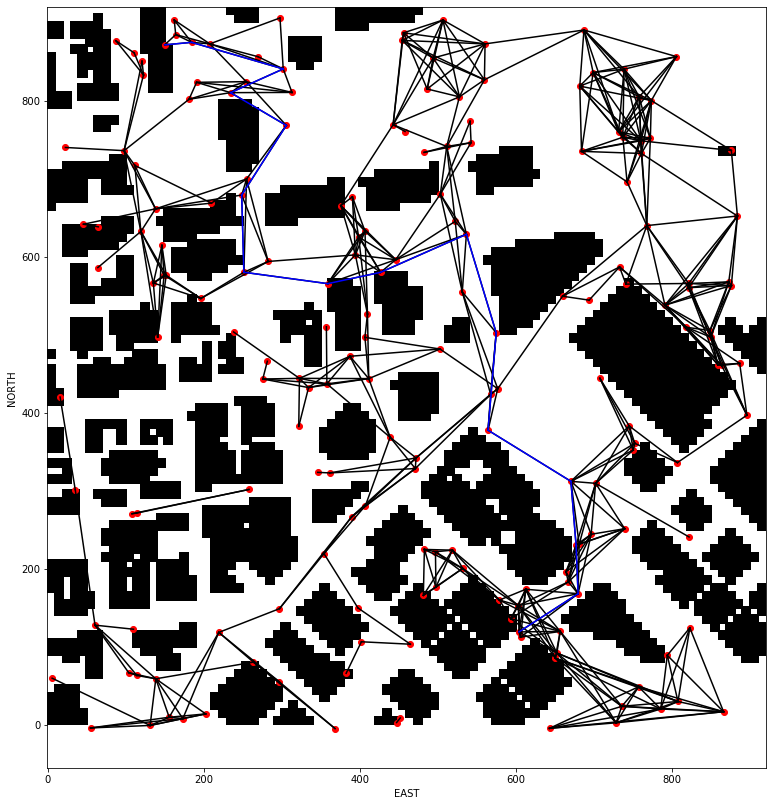

In [22]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'blue')

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)